In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
import os


Mounted at /content/gdrive/


In [2]:
import urllib.request
url, filename = ("https://github.com/burhanb7/FastDepth_model/raw/main/model_fastdepthv2.pth", "model_fastdepthv2.pth")
urllib.request.urlretrieve(url, filename)


('model_fastdepthv2.pth', <http.client.HTTPMessage at 0x7f626a333c90>)

Download The test images

In [3]:
for i in range(1,11,1):
  url = "https://github.com/burhanb7/FastDepth_model/raw/main/test"+str(i)+".png"
  filename= "test"+str(i)+".png"
  urllib.request.urlretrieve(url, filename)

In [4]:
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library
import cv2
import torch.nn.functional as F
import os
import torch
import torch.nn as nn
import torchvision.models
import collections
import math

In [5]:
def convlayer(in_channels,out_channels,kernel_size,stride):
    padding = 1
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU6(inplace=True),
        )

def mobilenetlayer(in_channels,out_channels,kernel_size,stride):
  padding = 1
  return nn.Sequential(
          nn.Conv2d(in_channels,in_channels,kernel_size,stride=stride,padding=padding,bias=False,groups=in_channels),
          nn.BatchNorm2d(in_channels),
          nn.ReLU6(inplace=True),
          nn.Conv2d(in_channels,out_channels,1,1,0,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU6(inplace=True),
    )
def depthwise(in_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,in_channels,kernel_size,stride=1,padding=padding,bias=False,groups=in_channels),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(inplace=True),
        )

def pointwise(in_channels, out_channels):
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,1,1,0,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )

In [6]:
class Encoder(nn.Module):
  def __init__(self):
        super(Encoder, self).__init__()
        kernel_size = 3
        self.conv0 = convlayer(3,16,kernel_size,2)
        self.conv1 = mobilenetlayer(16,56,kernel_size,1)
        self.conv2 = mobilenetlayer(56,88,kernel_size,2)
        self.conv3 = mobilenetlayer(88,120,kernel_size,1)
        self.conv4 = mobilenetlayer(120,144,kernel_size,2)
        self.conv5 = mobilenetlayer(144,256,kernel_size,1)
        self.conv6 = mobilenetlayer(256,408,kernel_size,2)
        self.conv7 = mobilenetlayer(408,376,kernel_size,1)
        self.conv8 = mobilenetlayer(376,272,kernel_size,1)
        self.conv9 = mobilenetlayer(272,288,kernel_size,1)
        self.conv10 = mobilenetlayer(288,296,kernel_size,1)
        self.conv11 = mobilenetlayer(296,328,kernel_size,1)
        self.conv12 = mobilenetlayer(328,480,kernel_size,2)
        self.conv13 = mobilenetlayer(480,512,kernel_size,1)
  def forward(self, x):
        for i in range(14):
            layer = getattr(self, 'conv{}'.format(i))
            x = layer(x)
            if i==1:
                x1 = x
            elif i==3:
                x2 = x
            elif i==5:
                x3 = x
        return x,x1,x2,x3

In [7]:
class Decoder(nn.Module):
  def __init__(self):
        super(Decoder, self).__init__()
        kernel_size = 5
        self.decode_conv1 = nn.Sequential(
            depthwise(512, kernel_size),
            pointwise(512, 200))
        self.decode_conv2 = nn.Sequential(
            depthwise(200, kernel_size),
            pointwise(200, 256))
        self.decode_conv3 = nn.Sequential(
            depthwise(256, kernel_size),
            pointwise(256, 120))
        self.decode_conv4 = nn.Sequential(
            depthwise(120, kernel_size),
            pointwise(120, 56))
        self.decode_conv5 = nn.Sequential(
            depthwise(56, kernel_size),
            pointwise(56, 16))
        self.decode_conv6 = pointwise(16, 1)
  def forward(self, x,x1,x2,x3):
        for i in range(1,6):
            layer = getattr(self, 'decode_conv{}'.format(i))
            x = layer(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            if i==4:
                x = x + x1
            elif i==3:
                x = x + x2
            elif i==2:
                x = x + x3
        x = self.decode_conv6(x)
        return x
        

In [8]:
class DepthEstimation(nn.Module):
  def __init__(self):
        super(DepthEstimation, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
  def forward(self,x):
        x,x1,x2,x3 = self.encoder(x)
        x = self.decoder(x,x1,x2,x3)
        return x

In [9]:
model_filename = 'model_fastdepthv2.pth'
model = torch.load(model_filename)

In [10]:
from PIL import Image
from torchvision import transforms
import pickle
preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

DepthEstimation(
  (encoder): Encoder(
    (conv0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (conv1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(16, 56, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=56, bias=False)
      (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(56, 88,

In [ ]:
train_dir = "gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepth_files/KITTI_Train/"
dataset = []
for i in range(2):
  pkl_file_name = train_dir+'kitty_dataset_val_orig' + str(i)+'.pkl'
  with open(pkl_file_name, 'rb') as pickle_file:
      dataset_t = pickle.load(pickle_file)
      dataset = dataset + dataset_t

gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepth_files/KITTI_Train/kitty_dataset_val_orig0.pkl
gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepth_files/KITTI_Train/kitty_dataset_val_orig1.pkl


In [ ]:
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
print(type(test_loader))
print(len(test_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
4944


In [ ]:
import math
def test_solver(model, test_loader):
  accuracy = []
  for x, y in test_loader:
    shape = [y.shape[1],y.shape[2]]
    with torch.no_grad():
      input_batch = x.to('cuda')
      y_pred = model(input_batch) 
    prediction = y_pred.reshape(y_pred.shape[0],y_pred.shape[2],y_pred.shape[3])
    prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=shape,
    mode="bicubic",
    align_corners=False,
    ).squeeze()
    output = prediction.cpu()
    abs_diff = (output - y).abs()
    percent_diff = (abs_diff/y)*100
    total_pixel = percent_diff.shape[1] * percent_diff.shape[2]
    test = percent_diff[percent_diff < 25.0]
    accuracy.append(test.shape[0]/total_pixel)
  print(sum(accuracy)/len(accuracy))
    

In [ ]:
test_solver(model,test_loader)

0.44370357509312675


In [11]:
import time
def forward_model_test(raw_img): 
  input_image = Image.open(raw_img).convert('RGB')
  shape = [input_image.size[1],input_image.size[0]]
  #shape = [224,224]
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  input_batch = input_batch.to('cuda')
  t1 = time.time()
  prediction = model(input_batch)
  t2 = time.time()
  prediction = prediction.reshape(1,224,224)
  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size=shape,
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  output = prediction.detach().cpu()
  return output,(t2-t1)

In [ ]:
model.eval()
import time
dataset_dir = 'KITTI_Raw/2011_09_26_drive_0001_sync/image_02/data/'
output_dir = 'Kitty_output_001_val_1000_train/'
for count, filename in enumerate(os.listdir(dataset_dir)):
  print(count)
  print(filename)
  filename1 = output_dir+filename
  x = dataset_dir+filename
  y,timex= forward_model_test(x)
  plt.imsave(filename1,y)

0.0074427127838134766


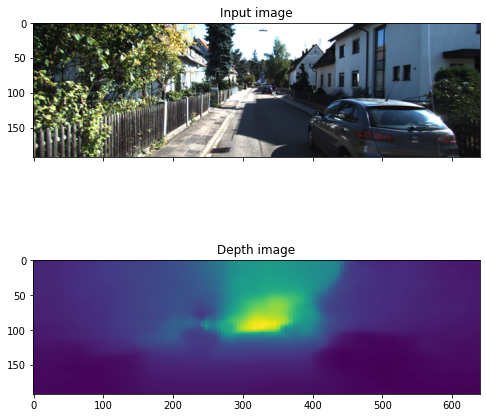

In [13]:
model.eval()
import time
x = "test3.png"
y,timex= forward_model_test(x)
input_image = Image.open(x).convert('RGB')
print(timex)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
axs[0].set_title('Input image')
axs[0].imshow(input_image, origin='upper')

axs[1].set_title('Depth image')
axs[1].imshow(y, origin='upper')
plt.show()

In [ ]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2_all.deb ...
Unpacking fonts-lato (2.0-2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.8-2_all.deb ...
Unpacking poppler-data (0.4.8-2) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.09_all.deb ...
Unpacking tex-common (6.09) ...
Selecting previously unselected package fonts-lmodern.
Preparing to unpack .../04-fonts-lmodern_2.004.5-3_all.deb ...
Unpacking fonts-lmodern (2.004.5-3) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .

In [ ]:
!jupyter nbconvert --to PDF "gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepthV2.ipynb"

[NbConvertApp] Converting notebook gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepthV2.ipynb to PDF
[NbConvertApp] Support files will be in FastDepthV2_files/
[NbConvertApp] Making directory ./FastDepthV2_files
[NbConvertApp] Writing 76241 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 207185 bytes to gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepthV2.pdf
